## SF Crime Analysis

In this notebook I'll use Spark to analyze [SFPD historical crime data from 2003 to 2018/05](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). My analysis would focus on exploring the data on important features such as time, space, crime categories, etc. using Spark SQL, Dataframe APIs, and k-means clustering.
<br><br>

## 1. Import packages and download data
<br>

In [ ]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/spark_hw1/data/sf_03_18.csv")
display(dbutils.fs.ls("dbfs:/spark_hw1/data/"))

path,name,size
dbfs:/spark_hw1/data/sf_03_18.csv,sf_03_18.csv,559169754


In [ ]:
data_path = "dbfs:/spark_hw1/data/sf_03_18.csv"

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# create dataframe and register tempview for sql query
df = spark.read.format("csv").option("header", "true").load(data_path)
df.createOrReplaceTempView("sf_crime")
display(df.limit(20))

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2
4018830907041,040188309,07041,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Sunday,02/15/2004,02:00,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90,POINT (-120.50000000000001 90),null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
13605159706372,136051597,06372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,03/14/2013,09:21,SOUTHERN,NONE,1300 Block of STEVENSON ST,-122.421594519119,37.7707674171464,POINT (-122.421594519119 37.7707674171464),32,1,10,20,8,2,9,28853,19,null,null,null,null,null,null,2,null,null,null,null,32
13618826906244,136188269,06244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,10/08/2013,19:30,MISSION,NONE,VALENCIA ST / DUBOCE AV,-122.422367409563,37.7698682392455,POINT (-122.422367409563 37.7698682392455),null,3,5,20,8,4,5,28853,19,null,null,null,3,null,null,2,null,null,3,null,null
4098938926105,040989389,26105,OTHER OFFENSES,FALSE REPORT OF BOMB,Sunday,08/29/2004,22:47,PARK,NONE,300 Block of WOODSIDE AV,-122.452716700987,37.7457451434135,POINT (-122.452716700987 37.7457451434135),49,7,8,38,1,5,4,59,38,null,null,null,null,null,null,1,null,null,null,null,49
5085058207021,050850582,07021,VEHICLE THEFT,STOLEN AUTOMOBILE,Friday,07/29/2005,21:00,INGLESIDE,NONE,0 Block of RAE AV,-122.448127287476,37.7121636146229,POINT (-122.448127287476 37.7121636146229),66,9,1,28,9,7,6,28861,25,null,null,null,null,null,null,2,null,null,null,null,66
13085582009320,130855820,09320,FRAUD,"CREDIT CARD, THEFT BY USE OF",Tuesday,10/08/2013,21:11,PARK,NONE,2600 Block of GEARY BL,-122.446612978839,37.7822458223917,POINT (-122.44661297883898 37.7822458223917),13,8,6,18,15,5,1,54,16,null,null,null,null,null,null,1,null,null,null,null,13
11091687865016,110916878,65016,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Sunday,11/13/2011,10:15,BAYVIEW,"ARREST, CITED",PHELPS ST / EVANS AV,-122.388456834121,37.7429830266541,POINT (-122.388456834121 37.7429830266541),86,2,9,1,10,3,8,58,1,null,null,null,null,null,null,1,null,null,null,null,86
5116515606241,051165156,06241,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Saturday,10/15/2005,13:00,RICHMOND,NONE,DIVISADERO ST / SUTTER ST,-122.439874051516,37.7852471617589,POINT (-122.439874051516 37.7852471617589),103,4,11,15,15,6,11,29490,13,null,null,null,null,null,null,2,null,null,null,null,103
5099200968020,050992009,68020,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Saturday,09/03/2005,21:21,TARAVAL,NONE,1500 Block of 12TH AV,-122.469264894685,37.7592163037102,POINT (-122.469264894685 37.7592163037102),109,10,8,14,1,8,4,56,12,null,null,null,null,null,null,1,null,null,null,null,109
9118446702004,091184467,02004,"SEX OFFENSES, FORCIBLE","FORCIBLE RAPE, BODILY FORCE",Monday,11/16/2009,12:49,TENDERLOIN,DISTRICT ATTORNEY REFUSES TO PROSECUTE,500 Block of JONES ST,-122.412999075009,37.786277459166,POINT (-122.412999075009 37.786277459166),20,5,10,36,5,10,9,28852,36,null,null,null,null,null,null,2,1,1,null,null,20


In [ ]:
df.count()

Out[5]: 2160953

## 2. Data preprocessing

Before the analysis, I'll preprocess the data by converting the datatypes of time/space features, and extract time-related features such as year, month, day of the week, etc.
<br><br>

In [ ]:
# convert datatypes for spacial and time-related features
from pyspark.sql.functions import col, to_date, to_timestamp, hour, date_format, year, month

df = df.withColumn('X', df.X.cast(FloatType())) \
       .withColumn('Y', df.Y.cast(FloatType())) \
       .withColumn('Date', to_date(df.Date, "MM/dd/yy")) \
       .withColumn('Time', to_timestamp(df.Time, "HH:mm")) \

# extract time-related features
df = df.withColumn('Hour', hour(df.Time)) \
       .withColumn('Year', year(df.Date)) \
       .withColumn('Month', month(df.Date))

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
display(df.limit(20))

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2,Hour,Year,Month
4018830907041,040188309,07041,VEHICLE THEFT,"VEHICLE, RECOVERED, AUTO",Sunday,2004-02-15,1970-01-01T02:00:00.000+0000,SOUTHERN,NONE,BRANNAN ST / 1ST ST,-120.5,90.0,POINT (-120.50000000000001 90),null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,2,2004,2
13605159706372,136051597,06372,LARCENY/THEFT,PETTY THEFT OF PROPERTY,Thursday,2013-03-14,1970-01-01T09:21:00.000+0000,SOUTHERN,NONE,1300 Block of STEVENSON ST,-122.42159,37.770767,POINT (-122.421594519119 37.7707674171464),32,1,10,20,8,2,9,28853,19,null,null,null,null,null,null,2,null,null,null,null,32,9,2013,3
13618826906244,136188269,06244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,2013-10-08,1970-01-01T19:30:00.000+0000,MISSION,NONE,VALENCIA ST / DUBOCE AV,-122.42237,37.769867,POINT (-122.422367409563 37.7698682392455),null,3,5,20,8,4,5,28853,19,null,null,null,3,null,null,2,null,null,3,null,null,19,2013,10
4098938926105,040989389,26105,OTHER OFFENSES,FALSE REPORT OF BOMB,Sunday,2004-08-29,1970-01-01T22:47:00.000+0000,PARK,NONE,300 Block of WOODSIDE AV,-122.45271,37.745747,POINT (-122.452716700987 37.7457451434135),49,7,8,38,1,5,4,59,38,null,null,null,null,null,null,1,null,null,null,null,49,22,2004,8
5085058207021,050850582,07021,VEHICLE THEFT,STOLEN AUTOMOBILE,Friday,2005-07-29,1970-01-01T21:00:00.000+0000,INGLESIDE,NONE,0 Block of RAE AV,-122.44813,37.712162,POINT (-122.448127287476 37.7121636146229),66,9,1,28,9,7,6,28861,25,null,null,null,null,null,null,2,null,null,null,null,66,21,2005,7
13085582009320,130855820,09320,FRAUD,"CREDIT CARD, THEFT BY USE OF",Tuesday,2013-10-08,1970-01-01T21:11:00.000+0000,PARK,NONE,2600 Block of GEARY BL,-122.44661,37.782246,POINT (-122.44661297883898 37.7822458223917),13,8,6,18,15,5,1,54,16,null,null,null,null,null,null,1,null,null,null,null,13,21,2013,10
11091687865016,110916878,65016,OTHER OFFENSES,"DRIVERS LICENSE, SUSPENDED OR REVOKED",Sunday,2011-11-13,1970-01-01T10:15:00.000+0000,BAYVIEW,"ARREST, CITED",PHELPS ST / EVANS AV,-122.38846,37.742985,POINT (-122.388456834121 37.7429830266541),86,2,9,1,10,3,8,58,1,null,null,null,null,null,null,1,null,null,null,null,86,10,2011,11
5116515606241,051165156,06241,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Saturday,2005-10-15,1970-01-01T13:00:00.000+0000,RICHMOND,NONE,DIVISADERO ST / SUTTER ST,-122.43987,37.785248,POINT (-122.439874051516 37.7852471617589),103,4,11,15,15,6,11,29490,13,null,null,null,null,null,null,2,null,null,null,null,103,13,2005,10
5099200968020,050992009,68020,OTHER OFFENSES,MISCELLANEOUS INVESTIGATION,Saturday,2005-09-03,1970-01-01T21:21:00.000+0000,TARAVAL,NONE,1500 Block of 12TH AV,-122.46926,37.759216,POINT (-122.469264894685 37.7592163037102),109,10,8,14,1,8,4,56,12,null,null,null,null,null,null,1,null,null,null,null,109,21,2005,9
9118446702004,091184467,02004,"SEX OFFENSES, FORCIBLE","FORCIBLE RAPE, BODILY FORCE",Monday,2009-11-16,1970-01-01T12:49:00.000+0000,TENDERLOIN,DISTRICT ATTORNEY REFUSES TO PROSECUTE,500 Block of JONES ST,-122.413,37.786278,POINT (-122.412999075009 37.786277459166),20,5,10,36,5,10,9,28852,36,null,null,null,null,null,null,2,1,1,null,null,20,12,2009,11


## <br> 3. Data exploration

I'll use Spark SQL and Dataframe APIs to explore the data, answer multiple questions of interest, and try to provide business insights and policy recommendations based on my findings.
<br><br>

### <br> 3.1 Major crime categories

How many categories of crime exist, and what are the major categories (categories with largest number of crime)?
<br><br>

In [ ]:
%sql
select count(distinct category) as number_of_categories
from sf_crime

number_of_categories
38


In [ ]:
sns.set_style("whitegrid")
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelpad"] = 10

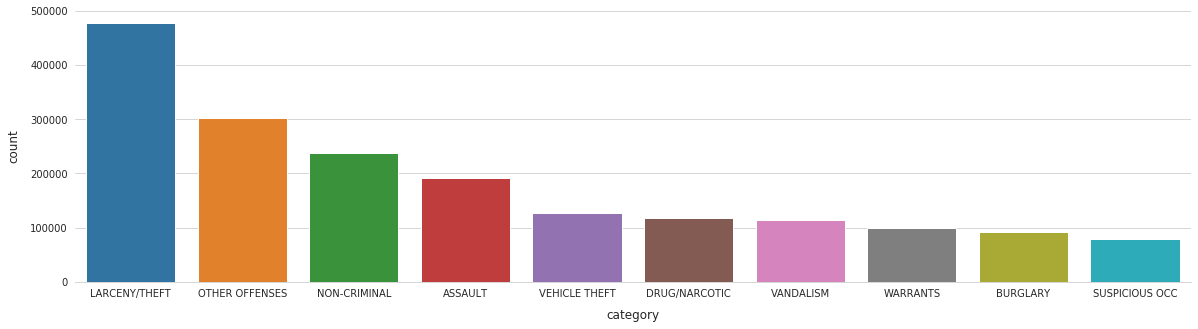

In [ ]:
category_count = df.groupBy('category').count().orderBy('count', ascending=False).toPandas()
fig, _ = plt.subplots(figsize=[20,5])
ax = sns.barplot(x='category', y='count', data=category_count.head(10), ci=None)
sns.despine(left=True)

<br>There are 38 crime categories in total, and major categories are theft, other offenses, non-criminal, assault, vehicle theft, etc.
<br><br>

### <br> 3.2 Number of crimes by district

How many crimes happened in each district, and which districts are the top dangerous districts in terms of the number of crimes?
<br><br>

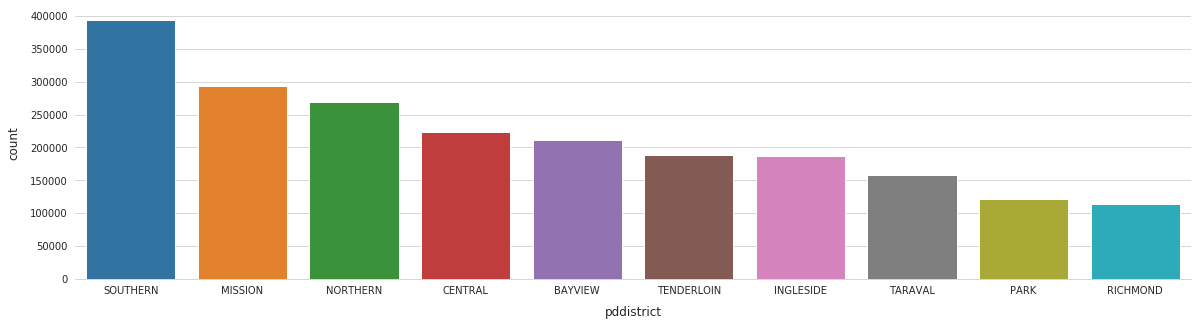

In [ ]:
district_count = df.groupBy('pddistrict').count().orderBy('count', ascending = False).toPandas()
fig, _ = plt.subplots(figsize=[20,5])
ax = sns.barplot(x='pddistrict', y='count', data=district_count, ci=None)
sns.despine(left=True)

<br>The total number of crimes from 2003 to 2018 in each district varied from 100,000 to 400,000; top-3 dangerous districts are Southern, Mission, and Northern.
<br><br>

### <br> 3.3 Number of crimes by category and hour within the top-3 dangerous districts

In the top-3 dangerous districts, what's the trend of crime events within a day and by major crime categories?
<br><br>

In [ ]:
top_category_hour = df.filter(col('PdDistrict').isin(['SOUTHERN', 'MISSION', 'NORTHERN'])) \
                      .groupBy('category', 'hour') \
                      .count() \
                      .orderBy('category', 'hour') \
                      .toPandas()

top_category_hour

Out[13]:

,category,hour,count
0,ARSON,0,84
1,ARSON,1,77
2,ARSON,2,84
3,ARSON,3,95
4,ARSON,4,74
...,...,...,...
870,WEAPON LAWS,19,462
871,WEAPON LAWS,20,398
872,WEAPON LAWS,21,460
873,WEAPON LAWS,22,492


In [ ]:
# transform from long to wide df to create a stacked plot
from matplotlib.colors import ListedColormap
top_category_hour_wide = top_category_hour[top_category_hour['count']>500].pivot_table(index='hour', 
                                                                                       columns='category', 
                                                                                       values='count')

sns.set_style("white")
plt.rcParams["figure.figsize"] = (20, 10)

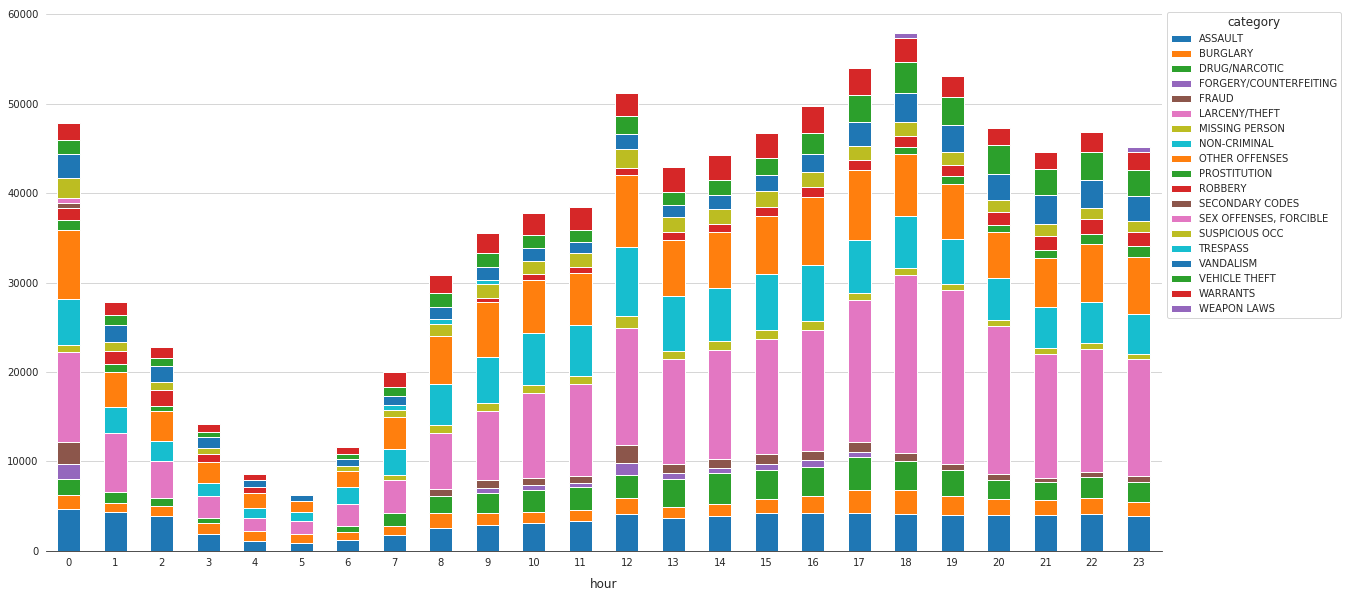

In [ ]:
ax = top_category_hour_wide.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette(n_colors=25)))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='category', title_fontsize=12)
plt.xticks(rotation=0)
ax.grid(axis='y')
sns.despine(left=True)

<br>

1. Within top-3 dangerous districts, the number of crimes within a day increases from 5am to 6pm, and decreases from 6pm to 5am in the next day. The highest and lowest number of crimes occur at 6pm and 5am, respectively.
2. The top categories of crimes in these districts are larceny/theft, other offenses, assault, and durg/narcotic.
3. More police officers should be on duty from noon to midnight, especially around 6pm; less should be on duty after midnight. Crimes such as theft, assualt, drug-related crime, and other offenses should be paid more attention to.
<br><br>

### 3.4 The number of crimes at Downtown SF by day of the week 

How many crimes happened at Downtown SF (the Financial District) by each day of the week and what's the trend in the most recent years (2017-2018)? To simplify the calculation, I'll use a rectangle of coordinates to represent the Downtown SF area.
<br><br>

In [ ]:
# downtown is defined by the rectangle of coordinates: -122.404693<X<-122.397896; 37.786672<Y<37.798982
X_dt = (-122.404693, -122.397896)
Y_dt = (37.786672, 37.798982)

def dt(x):
  if x < 0: # here x is the longitude
    return x > X_dt[0] and x < X_dt[1]
  else: # here x is the latitude
    return x > Y_dt[0] and x < Y_dt[1]

dt_udf = udf(lambda x: dt(x), BooleanType())
df_downtown = df.filter(dt_udf('X')) \
                .filter(dt_udf('Y'))
display(df_downtown.limit(20))

PdId,IncidntNum,Incident Code,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,location,SF Find Neighborhoods 2 2,Current Police Districts 2 2,Current Supervisor Districts 2 2,Analysis Neighborhoods 2 2,DELETE - Fire Prevention Districts 2 2,DELETE - Police Districts 2 2,DELETE - Supervisor Districts 2 2,DELETE - Zip Codes 2 2,DELETE - Neighborhoods 2 2,DELETE - 2017 Fix It Zones 2 2,Civic Center Harm Reduction Project Boundary 2 2,Fix It Zones as of 2017-11-06 2 2,DELETE - HSOC Zones 2 2,Fix It Zones as of 2018-02-07 2 2,"CBD, BID and GBD Boundaries as of 2017 2 2","Areas of Vulnerability, 2016 2 2",Central Market/Tenderloin Boundary 2 2,Central Market/Tenderloin Boundary Polygon - Updated 2 2,HSOC Zones as of 2018-06-05 2 2,OWED Public Spaces 2 2,Neighborhoods 2,Hour,Year,Month
3144161906224,031441619,06224,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Thursday,2003-12-11,1970-01-01T10:40:00.000+0000,CENTRAL,NONE,100 Block of SUTTER ST,-122.403366,37.789944,POINT (-122.40336641711201 37.7899452996011),19,6,3,8,4,1,10,28854,6,10,null,12,null,null,null,2,null,null,null,null,19,10,2003,12
13608058071000,136080580,71000,NON-CRIMINAL,LOST PROPERTY,Friday,2013-05-03,1970-01-01T12:10:00.000+0000,SOUTHERN,NONE,MISSION ST / 2ND ST,-122.3998,37.788006,POINT (-122.39980214579899 37.7880065324392),108,1,10,8,12,2,9,28855,6,null,null,null,null,null,3,1,null,null,null,null,108,12,2013,5
3093669164070,030936691,64070,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Thursday,2003-08-07,1970-01-01T12:00:00.000+0000,SOUTHERN,NONE,600 Block of MISSION ST,-122.4001,37.78769,POINT (-122.40010175016299 37.7876898900758),32,1,10,8,12,2,9,28855,6,null,null,null,null,null,4,1,null,null,null,null,32,12,2003,8
8126330006374,081263300,06374,LARCENY/THEFT,GRAND THEFT OF PROPERTY,Tuesday,2008-11-04,1970-01-01T00:01:00.000+0000,SOUTHERN,NONE,MARKET ST / 3RD ST,-122.403435,37.787643,POINT (-122.40343408674501 37.78764305018),19,6,3,8,12,2,10,28855,6,10,null,12,null,12,4,2,null,null,null,35,19,0,2008,11
10016528906244,100165289,06244,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Tuesday,2010-02-16,1970-01-01T18:00:00.000+0000,CENTRAL,NONE,500 Block of BATTERY ST,-122.40052,37.796345,POINT (-122.400517100596 37.7963438994583),77,6,3,8,3,1,10,28860,6,null,null,null,null,null,null,1,null,null,null,null,77,18,2010,2
13024973406303,130249734,06303,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Tuesday,2013-03-26,1970-01-01T12:10:00.000+0000,CENTRAL,NONE,0 Block of BUSH ST,-122.39941,37.79116,POINT (-122.39940279218001 37.7911607649989),108,6,3,8,4,1,10,28854,6,null,null,null,null,null,null,2,null,null,null,35,108,12,2013,3
7084282662050,070842826,62050,WARRANTS,ENROUTE TO OUTSIDE JURISDICTION,Sunday,2007-08-19,1970-01-01T07:10:00.000+0000,CENTRAL,"ARREST, BOOKED",400 Block of BROADWAY ST,-122.40428,37.798225,POINT (-122.404282497745 37.7982249345487),106,6,3,23,3,1,10,308,23,21,null,23,null,null,1,2,null,null,null,null,106,7,2007,8
6072220061040,060722200,61040,NON-CRIMINAL,"DEATH REPORT, NATURAL CAUSES",Saturday,2006-07-01,1970-01-01T10:00:00.000+0000,CENTRAL,NONE,0 Block of GEARY ST,-122.404274,37.787918,POINT (-122.404277568186 37.7879185264229),19,6,3,8,5,1,10,28857,6,10,null,12,null,12,5,2,null,null,null,null,19,10,2006,7
10102471771000,101024717,71000,NON-CRIMINAL,LOST PROPERTY,Saturday,2010-10-30,1970-01-01T13:30:00.000+0000,SOUTHERN,NONE,0 Block of NEWMONTGOMERY ST,-122.40174,37.788532,POINT (-122.40173828350602 37.7885335775983),108,6,10,8,12,2,9,28855,6,null,null,null,null,null,4,1,null,null,null,null,108,13,2010,10
4043442505033,040434425,05033,BURGLARY,"BURGLARY OF HOTEL ROOM, UNLAWFUL ENTRY",Thursday,2004-04-15,1970-01-01T08:00:00.000+0000,CENTRAL,NONE,100 Block of SUTTER ST,-122.40334,37.789837,POINT (-122.403344544792 37.7898368259498),19,6,3,8,4,1,10,28854,6,10,null,12,null,null,null,2,null,null,null,null,19,8,2004,4


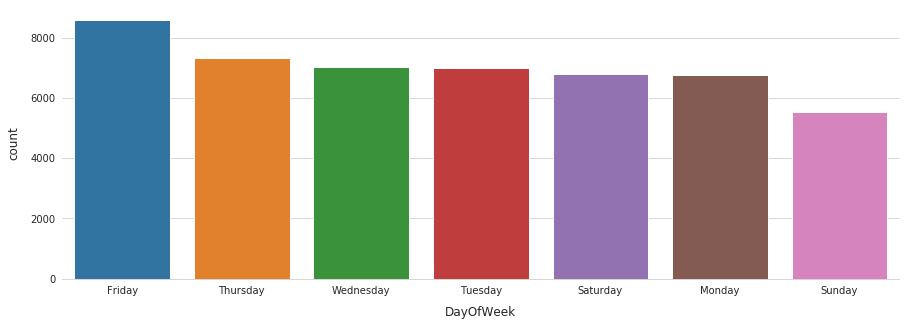

In [ ]:
dt_week = df_downtown.groupBy('DayOfWeek').count().orderBy('count', ascending=False).toPandas()
sns.set_style('whitegrid')
fig, _ = plt.subplots(figsize=[15,5])
ax = sns.barplot(x='DayOfWeek', y='count', data=dt_week, ci=None)
sns.despine(left=True)

<br> In Downtown SF, the days of week when crime happend most/least often were Friday and Sunday, respectively.
<br><br>

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

def week_df(dayOfWeek):
  ret = df_downtown.filter((df_downtown.Year>2016)&(df_downtown.DayOfWeek==dayOfWeek)) \
                   .groupBy('date') \
                   .count() \
                   .orderBy('date') \
                   .withColumn('week', row_number().over(Window.orderBy('date'))) \
                   .toPandas()
  ret['DayOfWeek'] = dayOfWeek
  return ret

mon = week_df('Monday')
tue = week_df('Tuesday')
wed = week_df('Wednesday')
thu = week_df('Thursday')
fri = week_df('Friday')
sat = week_df('Saturday')
sun = week_df('Sunday')
week_count = pd.concat([mon, tue, wed, thu, fri, sat, sun])

sns.set_style('whitegrid')

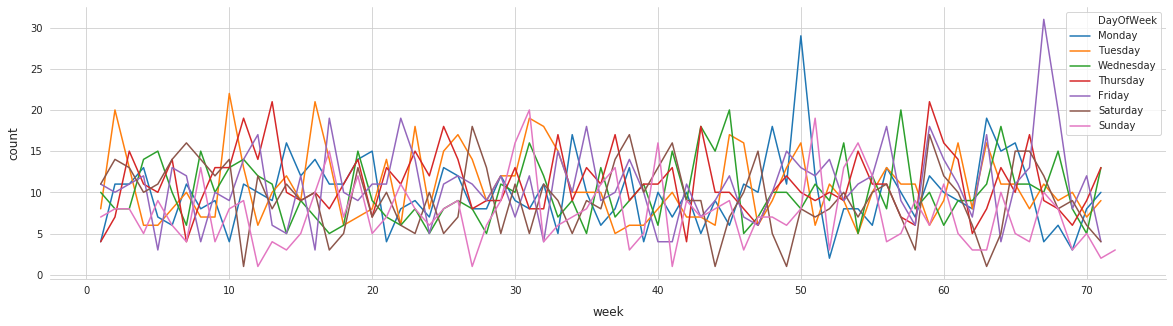

In [ ]:
fig, _ = plt.subplots(figsize=[20,5])
ax = sns.lineplot(x='week', y='count', data=week_count, hue='DayOfWeek')
plt.legend(title_fontsize=12)
sns.despine(left=True)

<br>

1. From 2017 to 2018, the number of crimes each day at SF Downtown was below 20 at most time, with the highest number of 31 on Friday.
2. There was no obvious trend of crime count from day to day, or during the two years.
<br><br>

### 3.5 The number of crime by month during 2015-2018

What's the trend of crime count from 2015 to 2018 by month?
<br><br>

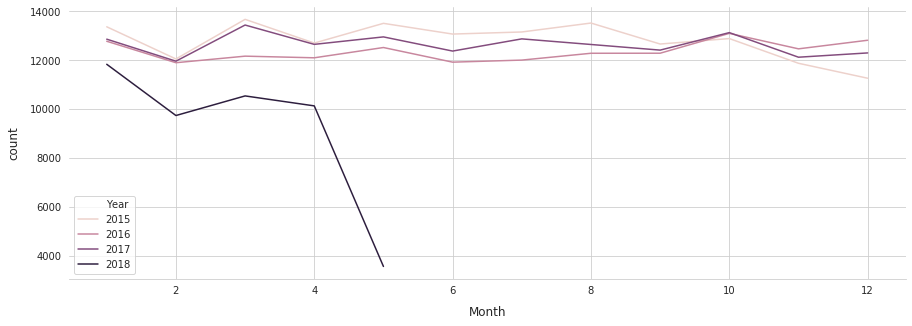

In [ ]:
month_count = df.filter(df.Year>2014).groupby('Year', 'Month').count().orderBy('year', 'month').toPandas()
fig, _ = plt.subplots(figsize=[15,5])
ax = sns.lineplot(x='Month', y='count', data=month_count, hue='Year')
plt.legend(title_fontsize=12)
sns.despine(left=True)

In [ ]:
from pyspark.sql.functions import dayofmonth
df = df.withColumn('DayOfMonth', dayofmonth(df.Date))
display(df.filter('year = 2018 and month = 5').agg({'dayofmonth':'max'}))

max(dayofmonth)
15


<br>

1. From 2015 to 2018, the number of crimes in each month in SF fluctuated between 11,000 and 14,000.
2. In 2018, the number of crimes in each month dropped sharply compared to previous years, although only the first 5 months were included in the data, and in the last month (May) only 15 days were included. 
3. The biggest drop occurred at February, 2018 and May, 2018 (even if we multiply the number of crimes in May by 2, there would still be a large drop).
4. If the large drop in number of crimes in 2018 was caused by improvements in public safety, this could lead to a better commercial environment for stores, customers, investors, etc. However, given the number of crimes in 2018 was almost abnormally low, the number drops need further investigation. I'll investigate that by analyzing the trend of crimes by each day of the week during 2017-2018.
<br><br>

In [ ]:
def week_df_all(dayOfWeek):
  ret = df.filter((df.Year>2016)&(df.DayOfWeek==dayOfWeek)) \
                   .groupBy('date') \
                   .count() \
                   .orderBy('date') \
                   .withColumn('week', row_number().over(Window.orderBy('date'))) \
                   .toPandas()
  ret['DayOfWeek'] = dayOfWeek
  return ret

mon = week_df_all('Monday')
tue = week_df_all('Tuesday')
wed = week_df_all('Wednesday')
thu = week_df_all('Thursday')
fri = week_df_all('Friday')
sat = week_df_all('Saturday')
sun = week_df_all('Sunday')
week_count = pd.concat([mon, tue, wed, thu, fri, sat, sun])

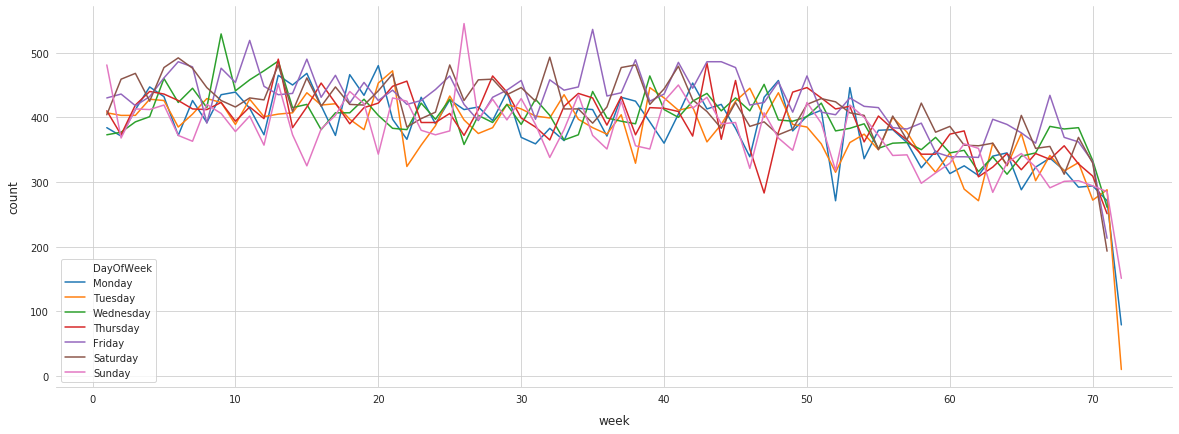

In [ ]:
fig, _ = plt.subplots(figsize=[20,7])
ax = sns.lineplot(x='week', y='count', data=week_count, hue='DayOfWeek')
plt.legend(title_fontsize=12)
sns.despine(left=True)

<br>

1. The crime trend by each day of week during 2017-2018 shows that in the first four months of 2018 (week 53-70), the number of crimes by each day was within the normal range.
2. However, in May 2018 (week 70-72), the number of crimes by each day was abnormally low, which means that the large drop from April 2018 to May 2018 in the last plot was probably due to some error in the data collecting process.
<br><br>

### 3.6 The number of crime by hour in Valentine's Days from 2015 to 2018

Valentine's Day is a big day for businesses and tourists. I'll analyze the trend of crimes by hour in Valentine's Days of recent years (2015-2018), and give my travel recommendations for tourists based on such trend.
<br><br>

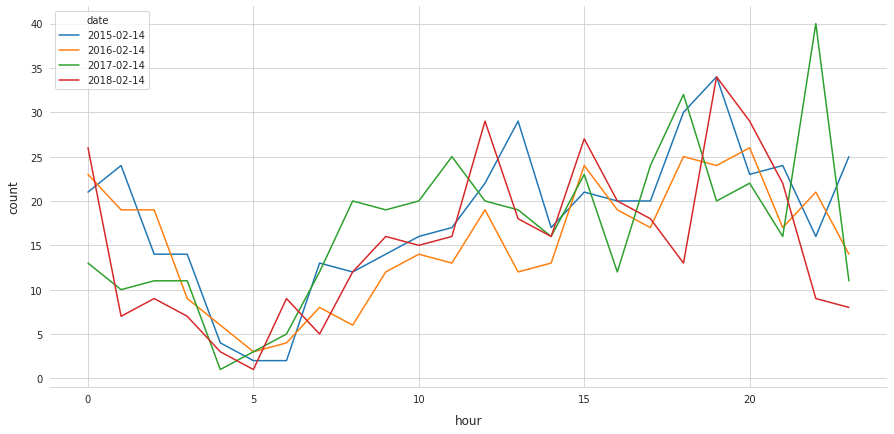

In [ ]:
# the number of crime by hours in Valentine's Days from 2015 to 2018
v_hour_count = df.filter((df.Year>2014) & (df.Month==2) & (df.DayOfMonth==14)).groupBy('date', 'hour').count().orderBy('date', 'hour').toPandas()
fig, _ = plt.subplots(figsize=[15,7])
ax = sns.lineplot(x='hour', y='count', data=v_hour_count, hue='date')
plt.legend(title_fontsize=12)
sns.despine(left=True)

<br>

1. From 2015 to 2018, the number of crimes in Valentine's Day drops during 12am to 5am, and reaches the lowest of a day around 5am, showing that there would be less crimes in Valentine's day at midnight.
2. The number of crimes rises after 5am, and reaches the first peak of a day around 12pm, with more than 20 crimes per hour.
3. In the afternoon (12-5pm) the number of crimes fluctuates between 10 crimes per hour to 30 crimes per hour.
4. The highest peak of crimes occurs in the evening, with more than 30 crimes per hour; the largest number was 40 crimes per hour at 10pm on 2017-02-14.
5. Although it has been shown that monthly crimes in 2018 has dropped compared to 2015-2017, crimes by hour in Valentine's Day of 2018 showes minor difference compared to 2015-2017.
6. Travel suggestion for visiting SF in Valentine's Day is that it's better to start travel early in the morning when it would be safer. Extra caution should be given during lunch time and dinner time, as well as early evening, when more crimes would happen.
<br><br>

### 3.7 The percentage of resolution for different crime categories

What's the percentage of resolution among all crime categories as well as major categories? To make the plots simpler, I'll label all resolutions as "resolved" except for "NONE" (which'll be labeled as "unresolved").
<br><Br>

In [ ]:
from pyspark.sql.functions import when, sum

df = df.withColumn('Resolution', \
                    (when(col('Resolution')=='NONE', 'unresolved') \
                    .otherwise('resolved')))

resolution_category_all = df.groupBy('Category', 'Resolution').count().orderBy('Category', 'Resolution')

window_spec = Window.partitionBy('Category')
resolution_category_all = resolution_category_all.withColumn('sum', sum(col('count')).over(window_spec)) \
                                                 .withColumn('percentage', col('count')/col('sum')*100) \
                                                 .toPandas()

sns.set_style("white")
plt.rcParams["figure.figsize"] = (20, 10)

resolution_category_all.head(20)

Category,Resolution,count,sum,percentage
ARSON,resolved,701,3875,18.09032258064516
ARSON,unresolved,3174,3875,81.90967741935484
ASSAULT,resolved,77637,191384,40.56608702921874
ASSAULT,unresolved,113747,191384,59.43391297078126
BAD CHECKS,resolved,180,924,19.480519480519483
BAD CHECKS,unresolved,744,924,80.51948051948052
BRIBERY,resolved,458,796,57.537688442211056
BRIBERY,unresolved,338,796,42.462311557788944
BURGLARY,resolved,14414,91067,15.82790692567011
BURGLARY,unresolved,76653,91067,84.1720930743299


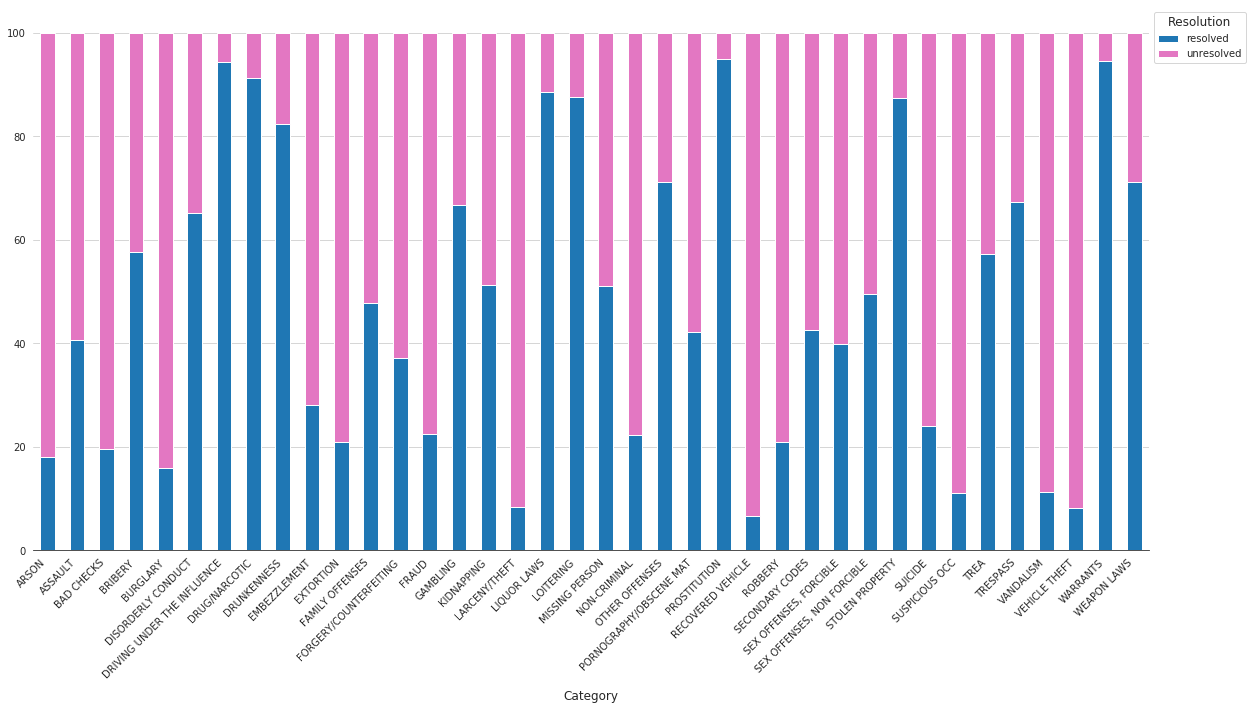

In [ ]:
resolution_category_all_wide = resolution_category_all.pivot_table(index='Category', 
                                                                   columns='Resolution', 
                                                                   values='percentage')

ax = resolution_category_all_wide.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette(n_colors=7)))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Resolution', title_fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y')
sns.despine(left=True)

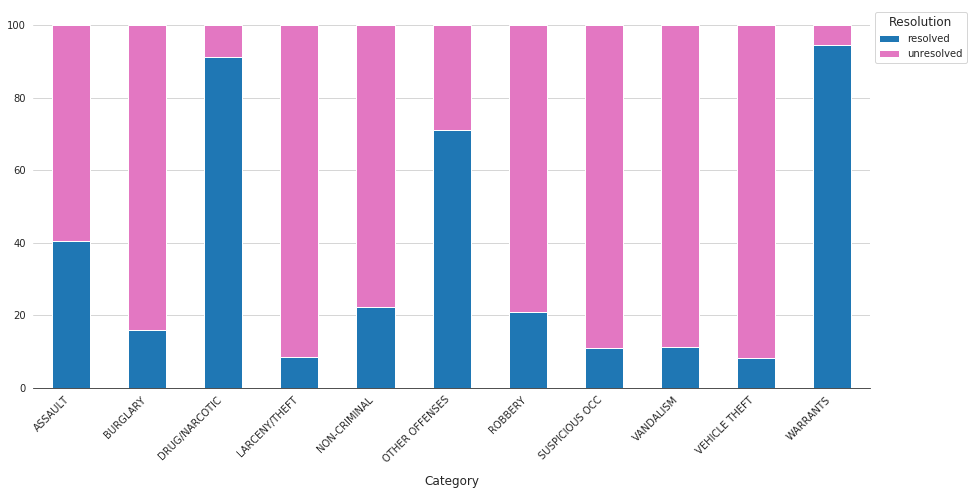

In [ ]:
resolution_category_major = resolution_category_all[resolution_category_all['sum']>50000] \
                                                   .pivot_table(index='Category', 
                                                                columns='Resolution', 
                                                                values='percentage')

plt.rcParams["figure.figsize"] = (15, 7)
ax = resolution_category_major.plot.bar(stacked=True, colormap=ListedColormap(sns.color_palette(n_colors=7)))
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Resolution', title_fontsize=12)
plt.xticks(rotation=45, ha='right')
ax.grid(axis='y')
sns.despine(left=True)

<br>

1. For all categories of crime, the percentage of unresolved crimes varies from 5% to 90%.
2. However, for the crimes that happened most often such as theft, assault, and burglary, the percentage of no resolution tends to be higher than 50%.
3. Given the low resolution rate especially among the major crime categories, the policy should be adjusted accordingly to improve the resolution rate.
4. Given the higher prequency but lower resolution rate of property crimes such as theft, burglary and robbery, it is recommended that greater police force be distributed for those crimes, which have a close and direct impact on residents' daily lives and the local economy.
<br><br>

## <br> 4. K-means clustering analysis on drug-related crimes

Drug-related crime has been a relatively serious problem in San Francisco. Does any geographical pattern exist for the previous drug-related crimes happened in San Francisco? I'll use k-means clustering to find that.
<br><br>

In [ ]:
from pyspark.ml.feature import VectorAssembler

df_drug = df.filter(col('Category')=='DRUG/NARCOTIC').select('X', 'Y', 'PdDistrict')
vecAssembler = VectorAssembler(inputCols=['X', 'Y'], outputCol='features')
df_drug = vecAssembler.transform(df_drug)
display(df_drug.limit(20))

X,Y,PdDistrict,features
-122.4308,37.78257,NORTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.43080139160156, 37.782569885253906))"
-122.414314,37.779835,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41431427001953, 37.77983474731445))"
-122.44319,37.732296,INGLESIDE,"Map(vectorType -> dense, length -> 2, values -> List(-122.44319152832031, 37.732295989990234))"
-122.41734,37.78238,NORTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41734313964844, 37.782379150390625))"
-122.3907,37.740482,BAYVIEW,"Map(vectorType -> dense, length -> 2, values -> List(-122.39070129394531, 37.740482330322266))"
-122.41127,37.78225,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41127014160156, 37.782249450683594))"
-122.41029,37.78223,SOUTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41029357910156, 37.782230377197266))"
-122.41199,37.785023,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.4119873046875, 37.7850227355957))"
-122.451645,37.719685,TARAVAL,"Map(vectorType -> dense, length -> 2, values -> List(-122.45164489746094, 37.71968460083008))"
-122.404655,37.73295,BAYVIEW,"Map(vectorType -> dense, length -> 2, values -> List(-122.40465545654297, 37.732948303222656))"


In [ ]:
df_drug.describe().show()

+-------+--------------------+------------------+----------+
summary| X| Y|PdDistrict|
+-------+--------------------+------------------+----------+
 count| 117875| 117875| 117875|
 mean| -122.4175340497208| 37.77427960499574| null|
 stddev|0.023008586421376917|0.4029362443987869| null|
 min| -122.51364| 37.708153| BAYVIEW|
 max| -120.5| 90.0|TENDERLOIN|
+-------+--------------------+------------------+----------+

<br>It seems that there are two outliers in the X and Y coordinates: X=-120.5, Y=90.0.
<br><br>

In [ ]:
#find out the outliers in the original dataset
df.select('X', 'Y').filter('X = -120.5').describe().show()

+-------+--------------------+----+
summary| X| Y|
+-------+--------------------+----+
 count| 142| 142|
 mean| -120.5|90.0|
 stddev|4.676575007961182...| 0.0|
 min| -120.5|90.0|
 max| -120.5|90.0|
+-------+--------------------+----+

In [ ]:
df.select('X', 'Y').filter('Y = 90.0').describe().show()

+-------+--------------------+----+
summary| X| Y|
+-------+--------------------+----+
 count| 142| 142|
 mean| -120.5|90.0|
 stddev|4.676575007961182...| 0.0|
 min| -120.5|90.0|
 max| -120.5|90.0|
+-------+--------------------+----+

<br>So all the outliers belong to one XY coordinate: (90, -120.5). Therefore we only need to specify one of the X and Y coordinates to drop them.
<br><br>

In [ ]:
#drop the outliers
df_drug = df_drug.filter('X != -120.5')
df_drug.describe().show()

+-------+-------------------+--------------------+----------+
summary| X| Y|PdDistrict|
+-------+-------------------+--------------------+----------+
 count| 117868| 117868| 117868|
 mean|-122.41764792913123| 37.77117799944746| null|
 stddev|0.01763644014514279|0.019304943205721018| null|
 min| -122.51364| 37.708153| BAYVIEW|
 max| -122.36494| 37.819977|TENDERLOIN|
+-------+-------------------+--------------------+----------+

In [ ]:
# build a k-means model with 10 clusters
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=10, seed=10)
model = kmeans.fit(df_drug.select('features'))

In [ ]:
model.summary.trainingCost # within-cluster sum-of-squares

Out[22]: 7.249773068332582

In [ ]:
transformed = model.transform(df_drug)
display(transformed.limit(20))

X,Y,PdDistrict,features,prediction
-122.4308,37.78257,NORTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.43080139160156, 37.782569885253906))",4
-122.414314,37.779835,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41431427001953, 37.77983474731445))",2
-122.44319,37.732296,INGLESIDE,"Map(vectorType -> dense, length -> 2, values -> List(-122.44319152832031, 37.732295989990234))",8
-122.41734,37.78238,NORTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41734313964844, 37.782379150390625))",2
-122.3907,37.740482,BAYVIEW,"Map(vectorType -> dense, length -> 2, values -> List(-122.39070129394531, 37.740482330322266))",5
-122.41127,37.78225,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41127014160156, 37.782249450683594))",2
-122.41029,37.78223,SOUTHERN,"Map(vectorType -> dense, length -> 2, values -> List(-122.41029357910156, 37.782230377197266))",2
-122.41199,37.785023,TENDERLOIN,"Map(vectorType -> dense, length -> 2, values -> List(-122.4119873046875, 37.7850227355957))",2
-122.451645,37.719685,TARAVAL,"Map(vectorType -> dense, length -> 2, values -> List(-122.45164489746094, 37.71968460083008))",6
-122.404655,37.73295,BAYVIEW,"Map(vectorType -> dense, length -> 2, values -> List(-122.40465545654297, 37.732948303222656))",1


In [ ]:
df_transformed = transformed.select('X', 'Y', 'PdDistrict', 'prediction').toPandas()
df_transformed

Out[25]:

,X,Y,PdDistrict,prediction
0,-122.430801,37.782570,NORTHERN,4
1,-122.414314,37.779835,TENDERLOIN,2
2,-122.443192,37.732296,INGLESIDE,8
3,-122.417343,37.782379,NORTHERN,2
4,-122.390701,37.740482,BAYVIEW,5
...,...,...,...,...
117863,-122.425728,37.777912,NORTHERN,4
117864,-122.415504,37.781654,TENDERLOIN,2
117865,-122.416344,37.782448,TENDERLOIN,2
117866,-122.416771,37.779583,NORTHERN,2


In [ ]:
centers = pd.DataFrame(model.clusterCenters(), columns=['X', 'Y'])
centers

Out[26]:

,X,Y
0,-122.404025,37.791549
1,-122.404104,37.719825
2,-122.412759,37.782512
3,-122.454511,37.769215
4,-122.430116,37.783575
5,-122.390563,37.737151
6,-122.461127,37.718675
7,-122.419017,37.761968
8,-122.431526,37.727469
9,-122.490801,37.758924


In [ ]:
sns.set_style('white')

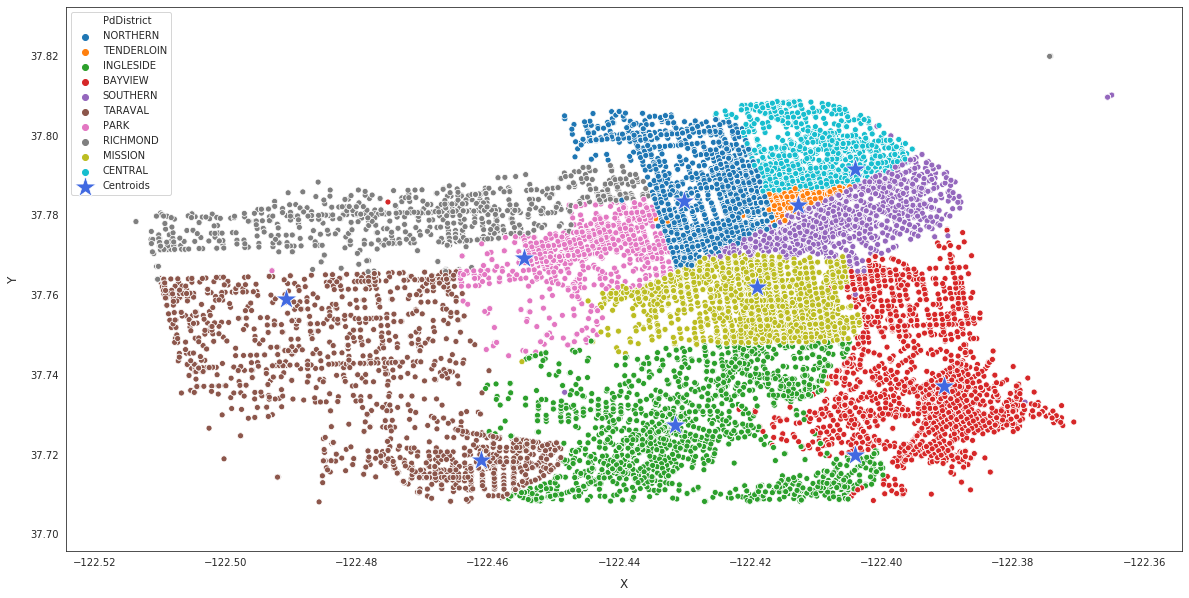

In [ ]:
# the scatterplot of districts where drug crimes happened
fig, _ = plt.subplots(figsize=[20,10])
ax = sns.scatterplot(data=df_transformed, x='X', y='Y', hue='PdDistrict')
plt.legend(title_fontsize=12)
ax = sns.scatterplot(data=centers, x='X', y='Y', marker='*', s=500, color='royalblue', label='Centroids')

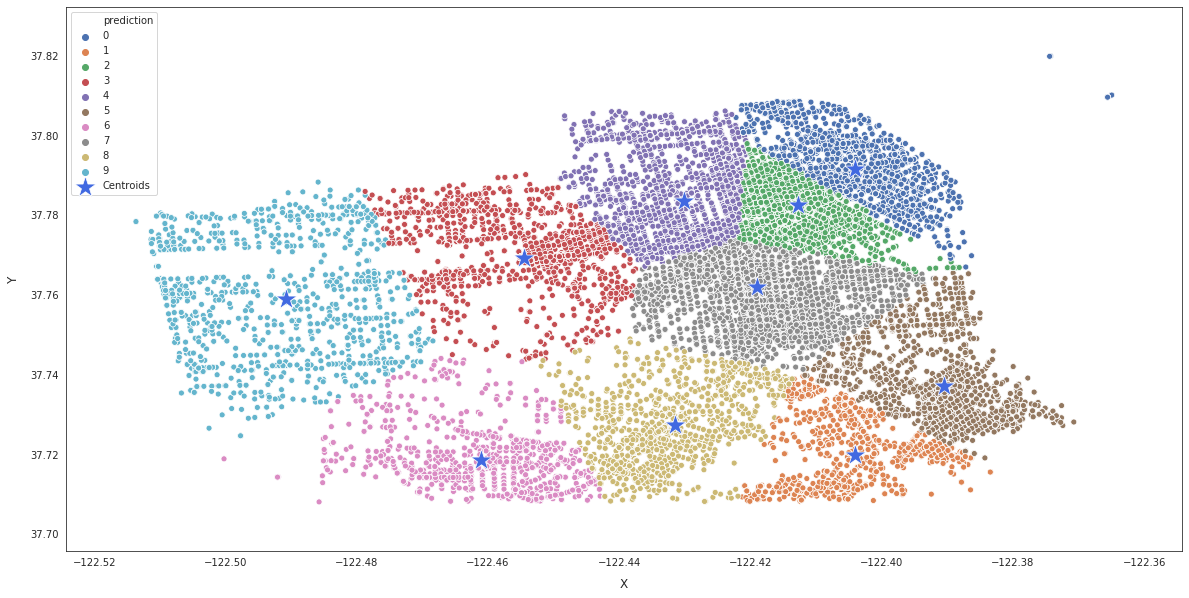

In [ ]:
# the scatterplot of predicted clusters
fig, _ = plt.subplots(figsize=[20,10])
ax = sns.scatterplot(data=df_transformed, x='X', y='Y', hue='prediction', palette='deep')
plt.legend(title_fontsize=12)
ax = sns.scatterplot(data=centers, x='X', y='Y', marker='*', s=500, color='royalblue', label='Centroids')

In [ ]:
#the number of coordinates within each predicted cluster
transformed.createOrReplaceTempView('clusters')
spark.sql('select prediction, count(X) as number_of_coordinates from clusters group by prediction order by prediction').show()

+----------+---------------------+
prediction|number_of_coordinates|
+----------+---------------------+
 0| 3756|
 1| 2359|
 2| 64307|
 3| 6446|
 4| 5296|
 5| 7903|
 6| 2262|
 7| 20509|
 8| 3148|
 9| 1882|
+----------+---------------------+

#### <br>Findings:
1. Drug-related crimes tended to happen most often in northern and eastern SF, while least often in western SF.
2. Cluster 2 and Cluster 7 had far more incidents than any other clusters, which include Tenderloin, Central, Southern, and Mission districts.
3. Drug-related crimes in Tenderloin, Central, Southern, and Mission should be paid more attention to given the higher volume and density of incidents in these districts.
<br><br>

In [ ]:
#evaluate the clustering using silhouette score
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(transformed)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7163054887620866

<br>
Additionally, we can use the elbow method to find the optimal number of clusters:
<Br>

In [ ]:
#use the elbow method to find optimal number of clusters
distortions = []
for i in range(2, 16):
    km = KMeans(
        k=i, seed=10
    )
    km_model = km.fit(df_drug.select('features'))
    distortions.append(km_model.summary.trainingCost)

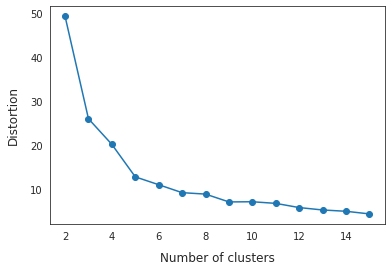

In [ ]:
plt.plot(range(2, 16), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

<br>The elbow is roughly at 9 clusters. Therefore, 10 clusters would be a little more than the optimal number, but still acceptable.
<br><br>

##Conclusion:
<br>

1. In the analysis above, I have performed a big data analysis on San Francisco historical crime data from 2003 to 2018 in order to obtain business insights through data exploration, particularly from two dimensions: time and location.
2. The basic assumption of this analysis is that crime is an important indicator of business - the rise of housing prices in San Francisco wouldn't be possible if crimes are rampant, and analysis of crime data would help to predict future economic situations.
3. I have used OLAP procedure to perform this analysis, based on Spark SQL; Dataframe has been used to load the large-sized data (over 2,000,000 rows) and data preprocessing has been performed on the time and spatial variables; data transformation has been used to explore the data and answer multiple questions of interest, and data visualization has been applied accordingly.
4. I have used K-means Clustering to identify clusters of drug-related crimes, and visualized these clusters as well as the districts where crimes happened. The clustering achived an silhouette score of 0.716.
5. In this analysis I have shown the trend of crime events over recent years and within any day, the distribution of crime events over categories and areas, as well as the resolution rate over crime categories. Based on these results, the predicted impact on business and recommendations for tourists as well as the police have been given.
<br><br>